<a href="https://colab.research.google.com/github/YairYarden/Deep-Learning/blob/feature%2Fassignment1_LeNet5/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code based on Udacity course

# Imports

In [ ]:
import torch
import numpy as np
from datetime import datetime 
import os

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, SubsetRandomSampler

import ssl

import matplotlib.pyplot as plt

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


CUDA is available!  Training on GPU ...


# Load Data

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.FashionMNIST('data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST('data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Visualize a batch of training data



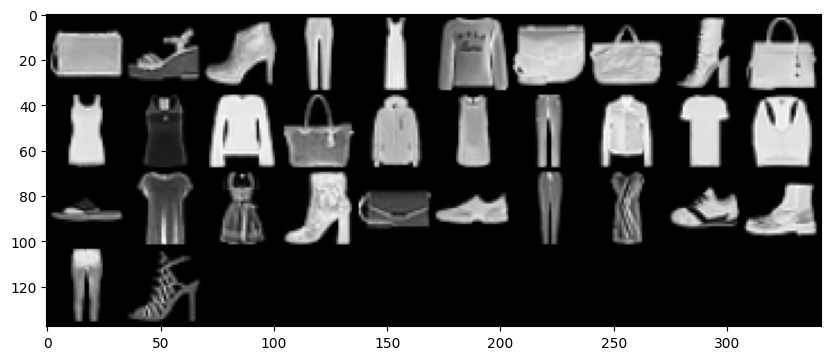

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=images, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");


# Define a Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class LeNet5(nn.Module):
    def __init__(self, n_classes=10, use_dropout=False, use_batchnorm=False):
        super(LeNet5, self).__init__()
        # convolutional layer (sees 32x32x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        # convolutional layer (sees 28x28x6 tensor)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        # convolutional layer (sees 10x10x16 tensor)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1)
        # max pooling layer
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Flatten 
        self.flatten = nn.Flatten(start_dim=1)
        # linear layer sees 120 -> 84
        self.fc1 = nn.Linear(in_features=120 , out_features=84)
        # linear layer (84 -> n_classes)
        self.fc2 = nn.Linear(in_features=84 , out_features=n_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.avg_pool(torch.tanh(self.conv1(x)))
        x = self.avg_pool(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        # flatten image input
        x = x.view(-1, 120)
        # add dropout layer
        # x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = torch.tanh(self.fc1(x))
        # add dropout layer
        # x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = LeNet5(10, use_dropout=False, use_batchnorm=False).to(DEVICE)
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


# Specify Loss function & Optimizer

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Functions For Training the network

In [ ]:
def compute_model_accuracy(model, data_loader, is_gpu_available):
    
    correct_pred = 0 
    num_examples = 0
    
    with torch.no_grad():
        model.eval()
        for data, target in data_loader:
            if is_gpu_available:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, predicted_labels = torch.max(output, 1) 
            
            num_examples += target.size(0)
            correct_pred += (predicted_labels == target).sum()

    return correct_pred.float() / num_examples
    
# --------------------------------------------------------------------------------------------------
def plot_train_and_valid_losses(train_losses, test_losses):
  
    train_losses = np.array(train_losses) 
    test_losses = np.array(test_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(test_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

# --------------------------------------------------------------------------------------------------
def train(train_loader, model, criterion, optimizer, is_gpu_available):
    running_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        running_loss += loss.item()*data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss
# --------------------------------------------------------------------------------------------------
def validate(test_loader, model, criterion, is_gpu_available):
    running_loss = 0.0

    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        running_loss += loss.item()*data.size(0)
    
    # calculate average losses
    valid_loss = running_loss/len(valid_loader.sampler)
               
    return model, valid_loss      
# --------------------------------------------------------------------------------------------------
def training_loop(model,
                  criterion,
                  optimizer,
                  train_loader,
                  test_loader,
                  epochs,
                  is_gpu_available,
                  log_dir: str = None):
     
    # set objects for storing metrics
    train_losses = []
    test_losses = []

    writer = SummaryWriter(log_dir=log_dir, flush_secs=10)

    print(f'{datetime.now().time().replace(microsecond=0)} START')

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, is_gpu_available)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = validate(test_loader, model, criterion, is_gpu_available)
            test_losses.append(test_loss)

            train_acc = compute_model_accuracy(model, train_loader, is_gpu_available)
            test_acc = compute_model_accuracy(model, test_loader, is_gpu_available)
                
        
        writer.add_scalars("Loss/", {'train': train_loss, 'test': test_loss}, epoch)
        writer.add_scalars("Accuracy/", {'train': train_acc, 'test': test_acc}, epoch)

        print(
          f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Epoch: {epoch}\t'
          f'Train loss: {train_loss:.4f}\t'
          f'Test loss: {test_loss:.4f}\t'
          f'Train accuracy: {train_acc:.4f}\t'
          f'Test accuracy: {test_acc:.4f}'
        )

    
    writer.flush()
    writer.close()
    plot_train_and_valid_losses(train_losses, test_losses)
    
    return model, optimizer, (train_losses, test_losses)

# --------------------------------------------------------------------------------------------------
def train_and_save(epochs, use_dropout=False, use_batchnorm=False, 
                   use_weight_decay=False, learning_rate=0.001, 
                   n_classes=10, exp_name='', is_gpu_available = False):
  if use_dropout:
      exp_name += '_DR'
  if use_batchnorm:
      exp_name += '_BN'
  if use_weight_decay:
      exp_name += '_WD'

  # setup
  RANDOM_SEED = 42
  torch.manual_seed(RANDOM_SEED)

  weight_decay = 0.01 if use_weight_decay else 0.0

  model = LeNet5(n_classes,
                use_dropout=use_dropout,
                use_batchnorm=use_batchnorm).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()


  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}_{exp_name}'
  run_log_dir = f'runs/{model_name}'

  # train
  model, optimizer, _ = training_loop(model, criterion, optimizer,
                                      train_loader, test_loader,
                                      epochs, is_gpu_available)

  # create checkpints folder
  os.makedirs('checkpoints', exist_ok=True)
  # save model
  ckpt_path = f'checkpoints/{model_name}.ckpt'
  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'use_dropout': use_dropout,
    'use_batchnorm': use_batchnorm,
    'epochs': epochs,
  }, ckpt_path)
  print(f'model saved to "{ckpt_path}"')

# Train the Network

21:39:56 START
21:40:28 --- Epoch: 0	Train loss: 0.4811	Test loss: 0.4702	Train accuracy: 0.8296	Test accuracy: 0.8200
21:41:00 --- Epoch: 1	Train loss: 0.3329	Test loss: 0.4031	Train accuracy: 0.8584	Test accuracy: 0.8424
Im here
Now im here
model saved to "checkpoints/22_03_04_21:39:56_.ckpt"


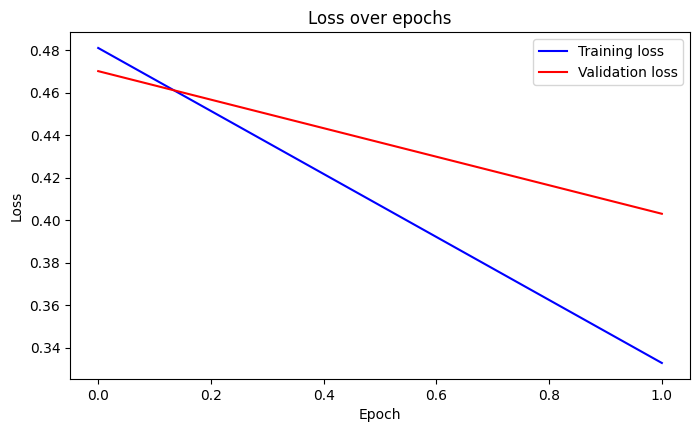

In [ ]:
num_epochs = 2
# basic network
train_and_save(num_epochs, use_dropout=False, use_batchnorm=False, use_weight_decay=False, is_gpu_available = is_gpu_available) 
# training_loop(model, criterion, optimizer, train_loader, test_loader, num_epochs, is_gpu_available) 